입력 이미지 크기: (664, 1000, 3)

0: 512x512 1 Defective, 16.4ms
Speed: 1.6ms preprocess, 16.4ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 512)
물체 감지: 클래스 1 | 신뢰도: 0.46 | 위치: (204.862548828125, 0.77703857421875) -> (512.0, 512.0)


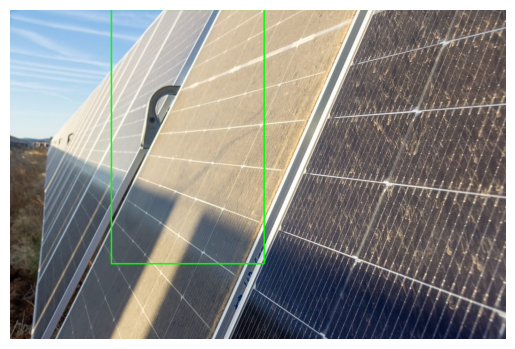

In [46]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

MODEL_PATH = "./runs/detect/train4/weights/best.pt"  # 모델 경로
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_PATH = '/home/xianghe/TRAININGYOLO11/testImage/dust_test.jpg'  # 테스트할 이미지 경로

# 모델 로드
model = YOLO(MODEL_PATH)
model = model.to(DEVICE)  # 디바이스로 이동

# 모델을 평가 모드로 설정 (학습 후 추론 모드로 전환)
model.eval()

# 이미지 읽기
image = cv2.imread(IMAGE_PATH)
if image is None:
    print(f"오류: 이미지를 로드할 수 없습니다: {IMAGE_PATH}")
else:
    print(f"입력 이미지 크기: {image.shape}")

    # BGR -> RGB 변환 (YOLO 모델은 RGB 입력을 받음)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # YOLO 모델에 맞게 이미지 리사이즈
    input_size = 512  # YOLO 모델이 요구하는 크기
    image_resized = cv2.resize(image_rgb, (input_size, input_size))

    # 모델에 입력하고 추론 실행
    results = model(image_resized)  # 모델에 이미지 바로 입력

    # 추론 결과 처리 (바운딩 박스 그리기)
    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].tolist()  # 바운딩 박스 좌표 (좌상단, 우하단)
        conf = result.conf[0].item()  # 신뢰도
        class_id = int(result.cls[0].item())  # 클래스 ID

        if conf > 0.01:  # 신뢰도가 0.01 이상인 경우만 처리
            print(f"물체 감지: 클래스 {class_id} | 신뢰도: {conf:.2f} | 위치: ({x1}, {y1}) -> ({x2}, {y2})")

            # 바운딩 박스 그리기 (BGR로 색상 설정)
            image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # 라벨 및 신뢰도 표시
            label = f"Class {class_id} {conf:.2f}"
            image = cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 결과 이미지 출력
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 다시 RGB로 변환
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO


MODEL_PATH = "./runs/detect/train3/weights/best.pt"  # 모델 경로
IMAGE_PATH = '/home/xianghe/TRAININGYOLO11/testImage/dust_test.jpg'  # 테스트할 이미지 경로

# 체크포인트 로드
model = YOLO(MODEL_PATH)
# ckpt = torch.load(MODEL_PATH, weights_only=False)  # 체크포인트 전체 로드
# model = ckpt['model']  # model 꺼내기
# model = model.autoshape() if hasattr(model, 'autoshape') else model  # autoshape 적용 (있으면)
model = model.to(DEVICE)  # 디바이스 보내기

results = model(IMAGE_PATH)


image 1/1 /home/xianghe/TRAININGYOLO11/testImage/dust_test.jpg: 288x416 1 clean, 18.7ms
Speed: 1.4ms preprocess, 18.7ms inference, 3.7ms postprocess per image at shape (1, 3, 288, 416)


In [42]:
len(results[0].boxes)

4

In [52]:
from datetime import datetime
from VideoStream import VideoStream
from ultralytics import YOLO
import cv2 as cv

MODEL_PATH = "./runs/detect/train3_fail/weights/best.pt"
model = YOLO(MODEL_PATH)
# model = model.to(DEVICE)  # 디바이스 보내기

stream = VideoStream("http://192.168.0.198:8000")
colors = np.random.uniform(0, 255, size=(len(model.names), 3))
def generate_frames():
	while True:
		frame = stream.get_frame()
		if frame is None:
			continue

		img = frame.copy()
		results = model(img)

		now = datetime.now()
		current_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
		cv.putText(img, current_time_str, (img.shape[1] - 630, img.shape[0] - 20),
				cv.FONT_HERSHEY_DUPLEX, 0.7, (83, 115, 219), 2)

		detected_this_frame = False
		frame_detected_names = set()

		for result in results:
			for box in result.boxes:
				x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
				conf = box.conf[0].item()
				cls = box.cls[0].item()
				class_index = int(cls)

				if class_index in target_class_indices and conf >= 0.4:
					detected_this_frame = True
					frame_detected_names.add(model.names[class_index])
					color = colors[class_index]
					cv.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
					cv.putText(img, f"{model.names[class_index]} {conf:.2f}",
							(int(x1), int(y1) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)
								
		_, buffer = cv.imencode('.jpg', img)
		frame_bytes = buffer.tobytes()
		yield (b'--frame\r\n'
			b'Content-Type:image/jpeg\r\n'
			b'Content-Length: ' + f"{len(frame_bytes)}".encode() + b'\r\n'
			b'\r\n' + frame_bytes + b'\r\n')